## Exercise 1.4 Hotdog -- no hotdog
This is the poster hand-in project for the course. Please see the associated PDF for instructions.

In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.models import efficientnet_b7, EfficientNet_B7_Weights

We always check that we are running on a GPU

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02516/

In [3]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

In [5]:
weights=EfficientNet_B7_Weights.IMAGENET1K_V1



size = 128
stats_transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
])

train_for_stats = Hotdog_NotHotdog(train=True, transform=stats_transform)

def compute_mean_std(dataset, batch_size=32):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    n_pixels = 0
    ch_sum = torch.zeros(3, dtype=torch.float64)
    ch_sq  = torch.zeros(3, dtype=torch.float64)
    for x, _ in loader:
        x = x.to(torch.float64)                
        b, c, h, w = x.shape
        n_pixels += b*h*w
        ch_sum += x.sum(dim=[0,2,3])
        ch_sq  += (x**2).sum(dim=[0,2,3])
    mean = (ch_sum / n_pixels).to(torch.float32)
    std  = (ch_sq / n_pixels - mean.double()**2).sqrt().to(torch.float32)
    return mean, std

mean, std = compute_mean_std(train_for_stats)
print(mean, std)

tensor([0.5226, 0.4412, 0.3585]) tensor([0.2696, 0.2631, 0.2734])


Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [6]:
size = 128
IMAGENET_MEAN = mean.tolist()
IMAGENET_STD  = std.tolist()
train_transform = transforms.Compose([
                                    transforms.RandomResizedCrop(size, scale=(0.7, 1.0), ratio=(0.75, 1.33)),
                                    transforms.RandomHorizontalFlip(p=0.5),
                                    transforms.RandomApply([transforms.ColorJitter(0.2, 0.2, 0.2, 0.1)], p=0.3),
                                    transforms.RandomRotation(45),
                                    transforms.ToTensor(),
                                    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),])
test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor(),
                                    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),])

batch_size = 32
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

Let's look at some images from our data 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9381906..2.1310503].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9381906..1.9302701].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9381906..2.346172].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9381906..2.088026].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9381906..2.346172].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9381906..2.346172].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9381906..0

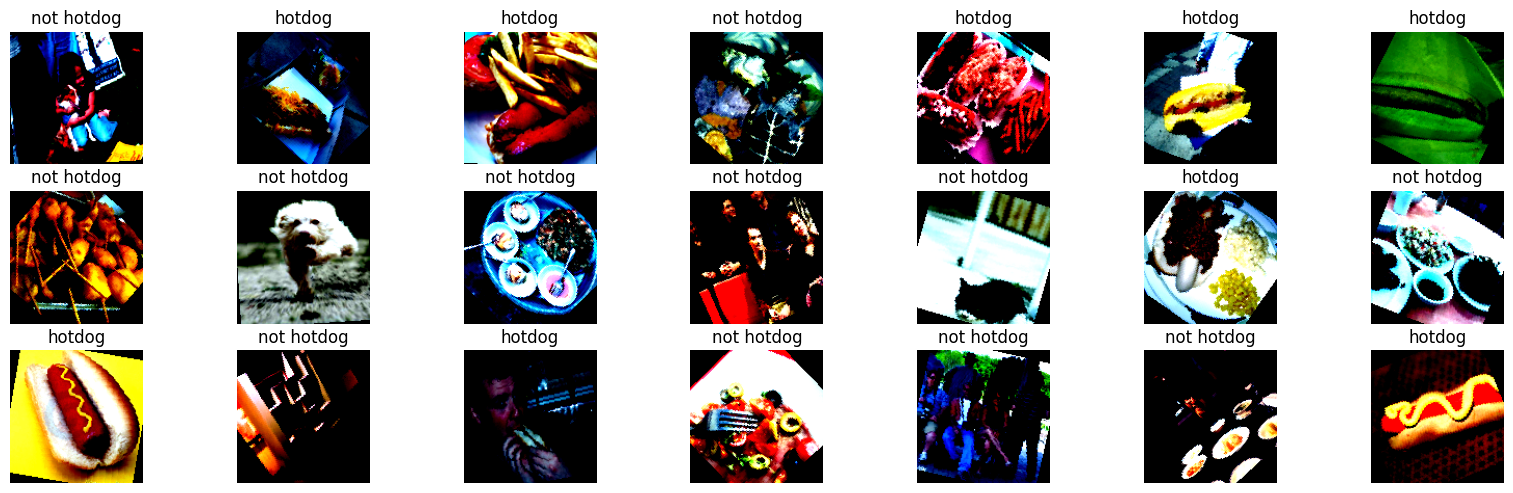

In [7]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')


Now create a model and train it!


In [8]:
def make_optimizer(name, params):
    name = name.lower()
    if name == "sgd":
        return torch.optim.SGD(params, lr=0.1)
    if name == "adam":
        return torch.optim.Adam(params, lr=0.001)
    raise ValueError(f"Unknown optimizer '{name}'")

In [9]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizerName, num_epochs=10):
    optimizer = make_optimizer(optimizerName, model.parameters())
    loss_fun = nn.CrossEntropyLoss()
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = loss_fun(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        #Comput the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(loss_fun(output, target).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
        out_dict['train_acc'].append(train_correct/len(trainset))
        out_dict['test_acc'].append(test_correct/len(testset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
    return out_dict

In [12]:
# accuracy ~81%
model1 =efficientnet_b7(weights=EfficientNet_B7_Weights.IMAGENET1K_V1)
# Replace 1000-class head with 2-class head
in_feats = model1.classifier[1].in_features   # Linear is at index 1
model1.classifier[1] = nn.Linear(in_feats, 2)

# (Option A) freeze backbone first, train only the head
for p in model1.features.parameters():
    p.requires_grad = False
# later unfreeze some/all and fine-tune with a smaller LR

model1.to(device)
out_dict = train(model1,"adam",20)

  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.564	 test: 0.485	 Accuracy train: 72.2%	 test: 79.0%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.481	 test: 0.438	 Accuracy train: 78.7%	 test: 81.6%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.453	 test: 0.423	 Accuracy train: 79.8%	 test: 82.4%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.436	 test: 0.415	 Accuracy train: 80.8%	 test: 81.8%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.424	 test: 0.422	 Accuracy train: 81.7%	 test: 81.1%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.434	 test: 0.420	 Accuracy train: 80.5%	 test: 81.4%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.420	 test: 0.417	 Accuracy train: 80.9%	 test: 81.4%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.435	 test: 0.415	 Accuracy train: 79.8%	 test: 80.8%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.419	 test: 0.414	 Accuracy train: 81.1%	 test: 81.5%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.407	 test: 0.414	 Accuracy train: 82.0%	 test: 81.4%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.431	 test: 0.413	 Accuracy train: 81.0%	 test: 81.6%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.424	 test: 0.415	 Accuracy train: 80.9%	 test: 81.0%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.415	 test: 0.414	 Accuracy train: 81.9%	 test: 81.4%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.419	 test: 0.411	 Accuracy train: 80.2%	 test: 82.0%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.402	 test: 0.412	 Accuracy train: 81.3%	 test: 81.5%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.430	 test: 0.413	 Accuracy train: 80.4%	 test: 81.3%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.410	 test: 0.406	 Accuracy train: 80.8%	 test: 81.9%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.420	 test: 0.407	 Accuracy train: 81.9%	 test: 82.1%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.417	 test: 0.414	 Accuracy train: 81.0%	 test: 81.6%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.417	 test: 0.414	 Accuracy train: 80.9%	 test: 81.5%


In [ ]:
#model1.save('EfficientNet_B7_Weights_adam_0_001.pth')
torch.save(model1.state_dict(), 'EfficientNet_B2_Weights_adam_0_001.pth')

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

# accuracy ~84%
#model1 =resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
#model1.to(device)
#out_dict = train(model1,"adam")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\kubko/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:09<00:00, 11.3MB/s]


  0%|          | 0/50 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 1.311	 test: 0.582	 Accuracy train: 71.5%	 test: 80.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.364	 test: 0.363	 Accuracy train: 84.5%	 test: 84.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.314	 test: 0.352	 Accuracy train: 86.4%	 test: 85.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.308	 test: 0.338	 Accuracy train: 86.3%	 test: 85.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.280	 test: 0.361	 Accuracy train: 87.8%	 test: 85.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.267	 test: 0.330	 Accuracy train: 88.7%	 test: 84.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.235	 test: 0.355	 Accuracy train: 90.9%	 test: 84.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.259	 test: 0.421	 Accuracy train: 89.7%	 test: 82.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.229	 test: 0.387	 Accuracy train: 90.3%	 test: 84.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.201	 test: 0.666	 Accuracy train: 91.6%	 test: 79.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.213	 test: 0.320	 Accuracy train: 91.2%	 test: 87.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.217	 test: 0.424	 Accuracy train: 91.3%	 test: 84.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.173	 test: 0.372	 Accuracy train: 93.1%	 test: 85.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.193	 test: 0.391	 Accuracy train: 92.8%	 test: 87.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.190	 test: 0.486	 Accuracy train: 92.3%	 test: 85.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.165	 test: 0.378	 Accuracy train: 93.3%	 test: 85.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.158	 test: 0.533	 Accuracy train: 93.8%	 test: 82.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.137	 test: 0.316	 Accuracy train: 95.1%	 test: 87.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.155	 test: 0.753	 Accuracy train: 93.9%	 test: 82.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.191	 test: 0.364	 Accuracy train: 92.5%	 test: 86.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.195	 test: 0.308	 Accuracy train: 92.4%	 test: 87.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.168	 test: 0.522	 Accuracy train: 92.8%	 test: 85.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.168	 test: 0.547	 Accuracy train: 92.8%	 test: 83.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.155	 test: 0.374	 Accuracy train: 93.5%	 test: 85.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.142	 test: 0.332	 Accuracy train: 94.5%	 test: 88.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.132	 test: 0.339	 Accuracy train: 94.6%	 test: 88.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.124	 test: 0.516	 Accuracy train: 95.0%	 test: 84.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.122	 test: 0.325	 Accuracy train: 95.5%	 test: 88.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.111	 test: 0.372	 Accuracy train: 95.7%	 test: 87.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.150	 test: 0.337	 Accuracy train: 94.0%	 test: 87.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.131	 test: 0.357	 Accuracy train: 95.0%	 test: 87.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.106	 test: 0.558	 Accuracy train: 95.6%	 test: 85.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.099	 test: 0.327	 Accuracy train: 96.3%	 test: 88.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.132	 test: 0.402	 Accuracy train: 94.8%	 test: 85.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.093	 test: 0.331	 Accuracy train: 96.8%	 test: 88.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.092	 test: 0.589	 Accuracy train: 96.3%	 test: 83.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.155	 test: 0.343	 Accuracy train: 93.8%	 test: 87.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.112	 test: 0.408	 Accuracy train: 95.5%	 test: 85.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.116	 test: 0.423	 Accuracy train: 95.6%	 test: 87.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.107	 test: 0.382	 Accuracy train: 96.1%	 test: 88.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.113	 test: 0.417	 Accuracy train: 95.7%	 test: 84.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.102	 test: 0.409	 Accuracy train: 96.1%	 test: 87.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.101	 test: 0.348	 Accuracy train: 95.9%	 test: 88.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.108	 test: 0.350	 Accuracy train: 96.1%	 test: 88.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.086	 test: 0.324	 Accuracy train: 97.0%	 test: 88.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.074	 test: 0.404	 Accuracy train: 97.4%	 test: 88.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.097	 test: 0.496	 Accuracy train: 96.9%	 test: 84.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.098	 test: 0.463	 Accuracy train: 96.1%	 test: 87.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.085	 test: 0.580	 Accuracy train: 97.0%	 test: 82.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.072	 test: 0.431	 Accuracy train: 97.3%	 test: 86.8%


In [8]:
class ResNetBlock(nn.Module):
    def __init__(self, n_features):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(n_features, n_features, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(n_features, n_features, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(n_features, n_features, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        identity = x                      # skip/identity branch
        x = self.conv1(x)
        x = F.relu(x)
        identity2 = x
        x = self.conv2(x)
        x = x + identity                   # F(x) + x
        x = F.relu(x)                 
        x = self.conv3(x)
        x = x + identity2 +identity                 # F(F(x)) + F(x) + x
        x = F.relu(x)
        return x

In [9]:
#Sanity test of your implementation
C = 4
res_block = ResNetBlock(C)
print(len(res_block.state_dict()))
assert(len(res_block.state_dict())==6)
for name, weight in res_block.state_dict().items():
    weight*=0
    desired_shape = {'bias': (C,), 'weight': (C, C, 3, 3)}[name.split('.')[-1]]
    assert(desired_shape==weight.shape)
x = torch.randn(32, C, 32,32)
assert(torch.abs(res_block(x)-F.relu(x)).max()==0)
print("Passed sanity check")

6
Passed sanity check


In [10]:
class ResNet(nn.Module):
    def __init__(self, n_in, n_features, num_res_blocks=3):
        super(ResNet, self).__init__()
        #First conv layers needs to output the desired number of features.
        conv_layers = [nn.Conv2d(n_in, n_features, kernel_size=3, stride=1, padding=1),
                       nn.ReLU()]
        for i in range(num_res_blocks):
            conv_layers.append(ResNetBlock(n_features))
        self.res_blocks = nn.Sequential(*conv_layers)
        self.fc = nn.Sequential(nn.Linear(128*128*n_features, 2048),
                                nn.ReLU(),
                                nn.Linear(2048, 2048),
                                nn.ReLU(),
                                nn.Linear(2048, 512),
                                nn.ReLU(),
                                nn.Linear(512,10))
        
    def forward(self, x):
        x = self.res_blocks(x)
        x = x.view(x.size(0), -1)
        out = self.fc(x)
        return out

In [ ]:
# accuracy ~75%
#model = ResNet(3, 8, num_res_blocks=3)
#model.to(device)
#out_dict = train(model,"adam")

  0%|          | 0/50 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 22.022	 test: 0.673	 Accuracy train: 47.3%	 test: 57.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.685	 test: 0.723	 Accuracy train: 58.4%	 test: 53.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.698	 test: 0.638	 Accuracy train: 58.4%	 test: 64.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.623	 test: 0.631	 Accuracy train: 65.3%	 test: 67.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.605	 test: 0.595	 Accuracy train: 68.1%	 test: 68.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.581	 test: 0.580	 Accuracy train: 70.3%	 test: 70.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.558	 test: 0.583	 Accuracy train: 72.5%	 test: 70.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.551	 test: 0.572	 Accuracy train: 73.6%	 test: 71.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.553	 test: 0.637	 Accuracy train: 72.5%	 test: 65.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.568	 test: 0.563	 Accuracy train: 71.1%	 test: 72.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.536	 test: 0.548	 Accuracy train: 74.2%	 test: 73.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.534	 test: 0.548	 Accuracy train: 73.6%	 test: 72.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.541	 test: 0.541	 Accuracy train: 73.7%	 test: 73.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.515	 test: 0.536	 Accuracy train: 76.2%	 test: 73.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.522	 test: 0.541	 Accuracy train: 73.8%	 test: 73.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.520	 test: 0.598	 Accuracy train: 75.7%	 test: 67.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.524	 test: 0.550	 Accuracy train: 74.6%	 test: 72.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.509	 test: 0.570	 Accuracy train: 76.0%	 test: 73.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.510	 test: 0.542	 Accuracy train: 76.9%	 test: 72.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.508	 test: 0.579	 Accuracy train: 75.8%	 test: 69.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.509	 test: 0.519	 Accuracy train: 75.5%	 test: 75.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.498	 test: 0.541	 Accuracy train: 75.9%	 test: 73.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.534	 test: 0.539	 Accuracy train: 73.2%	 test: 75.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.491	 test: 0.556	 Accuracy train: 76.3%	 test: 73.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.483	 test: 0.529	 Accuracy train: 77.8%	 test: 74.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.488	 test: 0.530	 Accuracy train: 77.2%	 test: 75.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.476	 test: 0.558	 Accuracy train: 77.1%	 test: 72.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.486	 test: 0.533	 Accuracy train: 76.7%	 test: 74.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.476	 test: 0.546	 Accuracy train: 78.1%	 test: 73.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.475	 test: 0.564	 Accuracy train: 77.9%	 test: 73.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.468	 test: 0.537	 Accuracy train: 78.0%	 test: 75.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.469	 test: 0.543	 Accuracy train: 78.1%	 test: 74.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.474	 test: 0.535	 Accuracy train: 77.5%	 test: 75.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.471	 test: 0.532	 Accuracy train: 78.1%	 test: 73.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.464	 test: 0.522	 Accuracy train: 79.1%	 test: 75.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.496	 test: 0.559	 Accuracy train: 75.5%	 test: 74.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.460	 test: 0.535	 Accuracy train: 78.6%	 test: 74.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.453	 test: 0.542	 Accuracy train: 79.2%	 test: 74.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.462	 test: 0.523	 Accuracy train: 80.0%	 test: 75.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.467	 test: 0.570	 Accuracy train: 77.7%	 test: 71.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.449	 test: 0.556	 Accuracy train: 78.7%	 test: 74.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.440	 test: 0.536	 Accuracy train: 79.2%	 test: 73.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.446	 test: 0.510	 Accuracy train: 79.6%	 test: 75.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.443	 test: 0.518	 Accuracy train: 79.6%	 test: 74.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.439	 test: 0.503	 Accuracy train: 80.1%	 test: 75.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.426	 test: 0.518	 Accuracy train: 79.7%	 test: 74.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.425	 test: 0.505	 Accuracy train: 81.3%	 test: 75.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.418	 test: 0.569	 Accuracy train: 81.8%	 test: 73.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.424	 test: 0.522	 Accuracy train: 79.9%	 test: 76.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.440	 test: 0.534	 Accuracy train: 79.2%	 test: 73.7%


Text(0, 0.5, 'Accuracy')

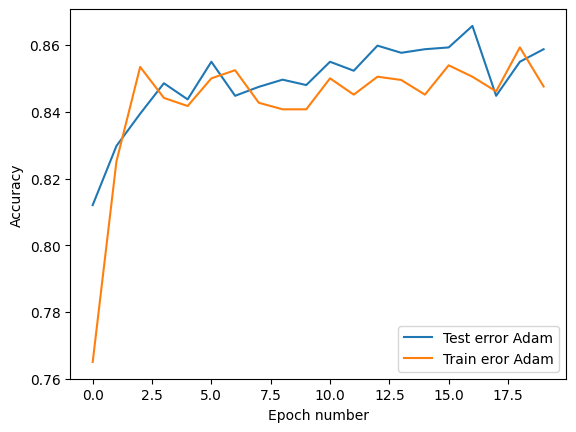

In [15]:
plt.plot(out_dict['test_acc'])
plt.plot(out_dict['train_acc'])
plt.legend(('Test error Adam', 'Train eror Adam'))
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')

Text(0, 0.5, 'LOSS')

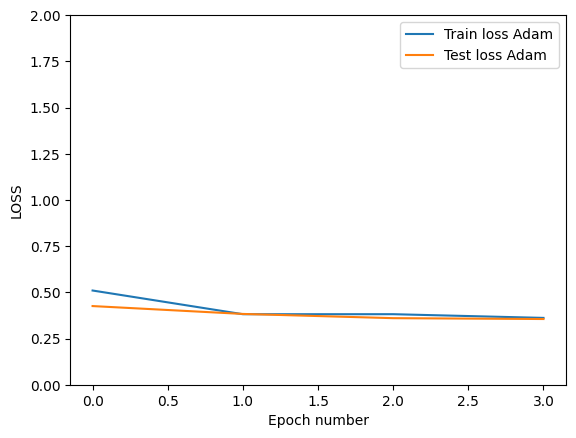

In [12]:
plt.plot(out_dict['train_loss'])
plt.plot(out_dict['test_loss'])
plt.ylim((0, 2))
plt.legend(('Train loss Adam', 'Test loss Adam'))
plt.xlabel('Epoch number')
plt.ylabel('LOSS')